# Results

In [168]:
import re
import ast
import json
import math
import numpy as np
import pandas as pd
from pathlib import Path
from collections import defaultdict
from metrics import score, recall, ndcg, mrr

In [170]:
def clean_string(string):
    if not string:
        return None
    return re.sub(r'\W+','', string).lower() 

def compute_results(trues, preds_annots):
    data = {}
    for k, preds in preds_annots.items():
        data[k] = score(trues, preds, [recall, ndcg, mrr], k=20)
    df = pd.DataFrame(data).transpose()
    df.loc['Mean'] = df.mean()
    return df.round(1)

def load_preds(path):
    preds = defaultdict(lambda: defaultdict(dict))
    for key_type in ["title", "id"]:
        for method in ["semantic_scholar", "google_scholar", "gpt-4o"]:
            if method == "gpt-4o":
                file_paths = [(Path(f'{path}/{method}/run{run_i}/preds_annot{annotator_i}.json'), f"annotator{annotator_i}_run{run_i}") for annotator_i in [1,2,3] for run_i in [1,2,3]]
            else:
                file_paths = [(Path(f'{path}/{method}/preds_annot{annotator_i}.json'),f"annotator{annotator_i}")  for annotator_i in [1,2,3]]
            for file_path in file_paths:
                preds[key_type][method][file_path[1]] = { id_:[clean_string(ref[key_type]) for ref in references] for id_, references in json.loads(file_path[0].read_text()).items()}
    return json.loads(json.dumps(preds))

In [147]:
reading_lists = pd.read_csv("../reading_lists.csv")
reading_lists['reading_list'] = reading_lists['reading_list'].apply(ast.literal_eval)

trues = {}
trues["title"] = { id_:[clean_string(ref["title"]) for ref in references] for id_, references in zip(reading_lists["id"], reading_lists["reading_list"]) }
trues["id"]  = { id_:[ref["paperId"] for ref in references] for id_, references in zip(reading_lists["id"], reading_lists["reading_list"]) }

preds = load_preds("preds_search_engines/preds")

# Comparing results using title and id matching

## Engine comparison using title matching

In [174]:
df1 = compute_results(trues["title"], {"PhD Student":preds["title"]["gpt-4o"]["annotator1_run1"], "Expert-Level":preds["title"]["gpt-4o"]["annotator2_run1"], "PhD-Level":preds["title"]["gpt-4o"]["annotator3_run1"]})
df2 = compute_results(trues["title"], {"PhD Student":preds["title"]["gpt-4o"]["annotator1_run2"], "Expert-Level":preds["title"]["gpt-4o"]["annotator2_run2"], "PhD-Level":preds["title"]["gpt-4o"]["annotator3_run2"]})
df3 = compute_results(trues["title"], {"PhD Student":preds["title"]["gpt-4o"]["annotator1_run3"], "Expert-Level":preds["title"]["gpt-4o"]["annotator2_run3"], "PhD-Level":preds["title"]["gpt-4o"]["annotator3_run3"]})
df = pd.concat([df1, df2, df3], axis=1, keys=["GPT-4o run 1", "GPT-4o run 2", "GPT-4o run 3"])
average_gpt4_run = ((df["GPT-4o run 1"] + df["GPT-4o run 2"] + df["GPT-4o run 3"]) / 3).round(1);
df_gpt4 = pd.concat([df1, df2, df3, average_gpt4_run], axis=1, keys=["GPT-4o run 1", "GPT-4o run 2", "GPT-4o run 3", "Average run"])

df1 = compute_results(trues["title"], {"PhD Student":preds["title"]["semantic_scholar"]["annotator1"], "Expert-Level":preds["title"]["semantic_scholar"]["annotator2"], "PhD-Level":preds["title"]["semantic_scholar"]["annotator3"]})
df2 = compute_results(trues["title"], {"PhD Student":preds["title"]["google_scholar"]["annotator1"], "Expert-Level":preds["title"]["google_scholar"]["annotator2"], "PhD-Level":preds["title"]["google_scholar"]["annotator3"]})
df3 = df_gpt4["Average run"]
df_engines = pd.concat([df1, df2, df3], axis=1, keys=["Semantic Scholar", "Google Scholar", "GPT-4o"]); df_engines

#print(df_engines.to_latex(float_format="{:0.1f}".format))

Semantic Scholar           Google Scholar            GPT-4o  \
                       recall ndcg  mrr         recall ndcg   mrr recall   
PhD Student               5.3  3.6  6.2            8.5  7.3  13.3   10.4   
Expert-Level              6.6  4.7  8.4            9.0  7.2  12.7   11.3   
PhD-Level                 4.0  3.2  5.9            5.4  4.9  10.1    9.5   
Mean                      5.3  3.8  6.8            7.6  6.5  12.0   10.4   

                          
              ndcg   mrr  
PhD Student    9.6  17.7  
Expert-Level  11.2  22.0  
PhD-Level      9.1  17.7  
Mean           9.9  19.2

## Comparison using Semantic Scholar paperId matching

In [176]:
df1 = compute_results(trues["id"], {"PhD Student":preds["id"]["gpt-4o"]["annotator1_run1"], "Expert-Level":preds["id"]["gpt-4o"]["annotator2_run1"], "PhD-Level":preds["id"]["gpt-4o"]["annotator3_run1"]})
df2 = compute_results(trues["id"], {"PhD Student":preds["id"]["gpt-4o"]["annotator1_run2"], "Expert-Level":preds["id"]["gpt-4o"]["annotator2_run2"], "PhD-Level":preds["id"]["gpt-4o"]["annotator3_run2"]})
df3 = compute_results(trues["id"], {"PhD Student":preds["id"]["gpt-4o"]["annotator1_run3"], "Expert-Level":preds["id"]["gpt-4o"]["annotator2_run3"], "PhD-Level":preds["id"]["gpt-4o"]["annotator3_run3"]})
df = pd.concat([df1, df2, df3], axis=1, keys=["GPT-4o run 1", "GPT-4o run 2", "GPT-4o run 3"])
average_gpt4_run = ((df["GPT-4o run 1"] + df["GPT-4o run 2"] + df["GPT-4o run 3"]) / 3).round(1);
df_gpt4 = pd.concat([df1, df2, df3, average_gpt4_run], axis=1, keys=["GPT-4o run 1", "GPT-4o run 2", "GPT-4o run 3", "Average run"])

df1 = compute_results(trues["id"], {"PhD Student":preds["id"]["semantic_scholar"]["annotator1"], "Expert-Level":preds["id"]["semantic_scholar"]["annotator2"], "PhD-Level":preds["id"]["semantic_scholar"]["annotator3"]})
df2 = compute_results(trues["id"], {"PhD Student":preds["id"]["google_scholar"]["annotator1"], "Expert-Level":preds["id"]["google_scholar"]["annotator2"], "PhD-Level":preds["id"]["google_scholar"]["annotator3"]})
df3 = df_gpt4["Average run"]
df_engines = pd.concat([df1, df2, df3], axis=1, keys=["Semantic Scholar", "Google Scholar", "GPT-4o"]); df_engines

#print(df_engines.to_latex(float_format="{:0.1f}".format))

Semantic Scholar           Google Scholar            GPT-4o  \
                       recall ndcg  mrr         recall ndcg   mrr recall   
PhD Student               5.3  3.6  6.2            8.4  7.2  13.0   11.3   
Expert-Level              6.6  4.7  8.4            8.8  7.1  12.7   12.4   
PhD-Level                 4.0  3.2  5.9            5.2  4.7   9.7   10.6   
Mean                      5.3  3.8  6.8            7.5  6.4  11.8   11.4   

                          
              ndcg   mrr  
PhD Student   10.6  19.3  
Expert-Level  12.6  25.5  
PhD-Level     10.4  20.9  
Mean          11.3  21.9

# Amount of undetermined ids per year

In [177]:
def mean_year(preds, year):    
    return np.mean([(len([v for v in vs if v])/len(vs) if len(vs) else 1) for k, vs in preds.items() if str(year) in k])

def mean_match_ids(preds):
    scores = defaultdict(lambda: defaultdict(dict))
    for year in [2020, 2021, 2022, 2023, 2024]:
        for key_type in ["id"]:
            for method in ["semantic_scholar", "google_scholar", "gpt-4o"]:
                if method == "gpt-4o":
                    scores[year][method] = np.mean([mean_year(preds[key_type][method][f"annotator{annotator_i}_run{run_i}"], year) for annotator_i in [1,2,3]for annotator_i in [1,2,3] for run_i in [1,2,3]])
                else:
                    scores[year][method] = np.mean([mean_year(preds[key_type][method][f"annotator{annotator_i}"], year) for annotator_i in [1,2,3]])
    return json.loads(json.dumps(scores))

<Axes: xlabel='year', ylabel='matches'>

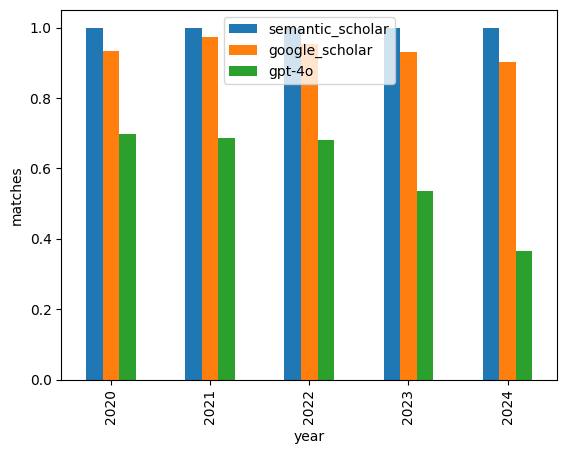

In [190]:
years = [2020, 2021, 2022, 2023, 2024]
data = defaultdict(list)
for i, method in enumerate(["semantic_scholar", "google_scholar", "gpt-4o"]):
    data["year"] = years
    for year in years:
        data[method].append(mean_match_ids(preds)[str(year)][method])
df = pd.DataFrame(data)
df.plot.bar(x="year", y=["semantic_scholar", "google_scholar", "gpt-4o"], ylabel="matches")